<a href="https://colab.research.google.com/github/masadeghi/lung_cancer_ctscan_survival/blob/main/image_processing_40samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [62]:
%%capture
!{sys.executable} -m pip install --upgrade --pre -q "itk==5.3rc4.post3"
!{sys.executable} -m pip install --upgrade --pre -q "itkwidgets[all]==1.0a20" imjoy_elfinder
!pip install SimpleITK
!pip install pydicom
!pip install nibabel
!pip install lifelines
!pip uninstall scikit-learn -y
!pip install -U scikit-learn # To update scikit-learn so that it is compatible with scikit-survival
!pip install scikit-survival

In [63]:
# download tcia_utils
tcia_utils_text = requests.get("https://github.com/kirbyju/TCIA_Notebooks/raw/main/tcia_utils.py")
with open('tcia_utils.py', 'wb') as f:
    f.write(tcia_utils_text.content)

In [64]:
import sys
import os
import requests
import random
import glob
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

import tcia_utils as tcia

import itk
import pydicom
import SimpleITK as sitk
import nibabel as nib
from itkwidgets import view

import tensorflow as tf
# import tensorflow.compat.v2.summary as summary
from tensorflow import keras
# from tensorflow.python.ops import summary_ops_v2
from tensorflow.keras import layers

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

import lifelines
from lifelines import KaplanMeierFitter as KM
from lifelines import AalenAdditiveFitter
from lifelines import CoxPHFitter

# Import data from TCIA

In [ ]:
# Shared cart with only the CT scans (without the reconstruct files) of the NSCLC-Radiomics dataset
# Full dataset: https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-56151670240280774

# data = tcia.getSharedCart(name = "nbia-56151670240280774")
# nsclc_data = tcia.downloadSeries(data, csv_filename = "my_shared_cart")
# display(nsclc_data)


# A small sample of 20 to get the code up and running:
# https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-30001670303233978


# Or a sample of 40:
# https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-47941670310489610

data = tcia.getSharedCart(name = "nbia-47941670310489610")
nsclc_data = tcia.downloadSeries(data, csv_filename = "my_shared_cart")
display(nsclc_data)

In [65]:
# If data already imported
nsclc_data = pd.read_csv("/content/my_shared_cart.csv", index_col = "Unnamed: 0")

# Convert the folder names of the imported files to their corresponding patient ID

In [67]:
paths = os.listdir("/content/tciaDownload")

for path in paths:
  if "1-001.dcm" in os.listdir(os.path.join("/content/tciaDownload", path)):
    image_path = os.path.join("/content/tciaDownload", path, "1-001.dcm")
  else:
    image_path = os.path.join("/content/tciaDownload", path, "1-01.dcm")
  image = pydicom.dcmread(image_path)
  patient_id = str(image.PatientName)[-3:]
  os.rename(os.path.join("/content/tciaDownload", path), os.path.join("/content/tciaDownload", patient_id))

# Converting DICOM series files into Nifti volumes

In [11]:
patient_folders = os.listdir("/content/tciaDownload")

os.mkdir("/content/nifti_images")

for patient in patient_folders:
  reader = sitk.ImageSeriesReader()
  dicom_names = reader.GetGDCMSeriesFileNames(os.path.join('/content/tciaDownload', patient))
  reader.SetFileNames(dicom_names)
  image = reader.Execute()

  # # A call to PermuteAxes to change the axes of the data
  # image = sitk.PermuteAxes(image, [1,0,2])

  sitk.WriteImage(image, f'/content/nifti_images/patient_{patient}.nii')

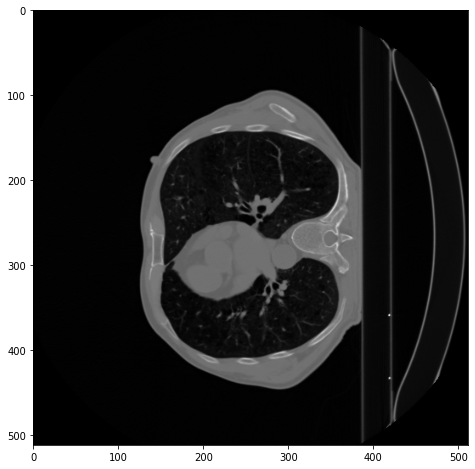

In [69]:
test_image = nib.load("/content/nifti_images/patient_015.nii").get_fdata()

plt.figure(figsize=(8, 8))
plt.imshow(test_image[:, :, 49], cmap = 'gray')

# Preprocessing data

## Helper functions

In [70]:
def read_nifti_file(filepath):
  scan = nib.load(filepath)
  scan = scan.get_fdata()
  return scan

def normalize(volume):
  min = -1000
  max = 400
  volume[volume < min] = min
  volume[volume > max] = max
  voume = (volume - min) / (max - min)
  volume = volume.astype("float32")
  return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    img = np.fliplr(img)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

## Divide image data into train-val-test sets

In [71]:
patient_files = os.listdir("/content/nifti_images")
random.seed(42)
random.shuffle(patient_files)

train_patients = patient_files[:int(len(patient_files) * 0.7)]
train_paths = [os.path.join("/content/nifti_images", patient) for patient in train_patients]

val_patients = patient_files[int(len(patient_files) * 0.7):int(len(patient_files) * 0.85)]
val_paths = [os.path.join("/content/nifti_images", patient) for patient in val_patients]

test_patients = patient_files[int(len(patient_files) * 0.85):]
test_paths = [os.path.join("/content/nifti_images", patient) for patient in test_patients]

## Import target survival data

In [72]:
clinical_data = pd.read_csv("/content/NSCLC-Radiomics clinical data.csv", index_col = 0)

clinical_data.head()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
PatientID,,,,,,,,,
LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


## Constructing survival curves

Text(0, 0.5, 'Frequencey (number of patients')

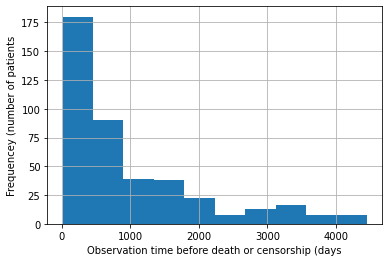

In [48]:
clinical_data["Survival.time"].hist();
plt.xlabel("Observation time before death or censorship (days");
plt.ylabel("Frequencey (number of patients")

In [49]:
def frac_censored(df):
    """
    Return percent of observations which were censored.
    
    Args:
        df (dataframe): dataframe which contains column 'Event' which is 
                        1 if an event occurred (death)
                        0 if the event did not occur (censored)
    Returns:
        frac_censored (float): fraction of cases which were censored. 
    """
    result = 0.0
    
    censored_count = df["deadstatus.event"] == 0
    result = sum(censored_count)/len(censored_count)
    
    return result

frac_censored(clinical_data)

0.11611374407582939

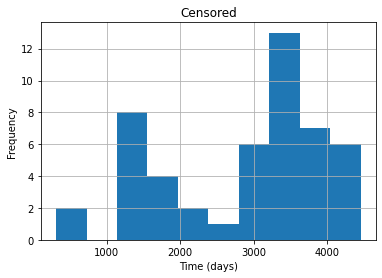

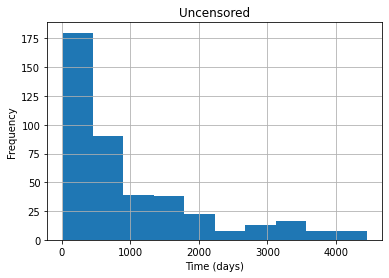

In [51]:
clinical_data_censored = clinical_data[clinical_data["deadstatus.event"] == 0]
clinical_data_uncensored = clinical_data[clinical_data["deadstatus.event"] == 1]

clinical_data_censored["Survival.time"].hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

clinical_data["Survival.time"].hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

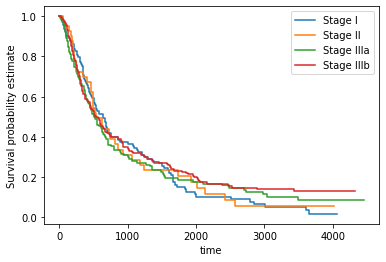

In [53]:
SI = clinical_data[clinical_data["Overall.Stage"] == 'I']
kmI = KM()
kmI.fit(SI.loc[:, "Survival.time"], event_observed = SI.loc[:, "deadstatus.event"], label = "Stage I")

SII = clinical_data[clinical_data["Overall.Stage"] == 'II']
kmII = KM()
kmII.fit(SII.loc[:, "Survival.time"], event_observed = SII.loc[:, "deadstatus.event"], label = "Stage II")

SIIIa = clinical_data[clinical_data["Overall.Stage"] == 'IIIa']
kmIIIa = KM()
kmIIIa.fit(SIIIa.loc[:, "Survival.time"], event_observed = SIIIa.loc[:, "deadstatus.event"], label = "Stage IIIa")

SIIIb = clinical_data[clinical_data["Overall.Stage"] == 'IIIb']
kmIIIb = KM()
kmIIIb.fit(SIIIb.loc[:, "Survival.time"], event_observed = SIIIb.loc[:, "deadstatus.event"], label = "Stage IIIb")

ax = kmI.plot(ci_show=False)
kmII.plot(ax = ax, ci_show=False)
kmIIIa.plot(ax = ax, ci_show=False)
kmIIIb.plot(ax = ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival probability estimate')
plt.savefig('four_km_curves', dpi=300)

In [64]:
non_missing_clinical_data = clinical_data.dropna(subset = ["age", "Overall.Stage", "gender"])

aaf = AalenAdditiveFitter()

aaf.fit(non_missing_clinical_data, duration_col = "Survival.time",
        event_col = "deadstatus.event", formula = "Overall.Stage + age + gender")

aaf.cumulative_hazards_.head()

covariate,Intercept,Overall.Stage[T.II],Overall.Stage[T.IIIa],Overall.Stage[T.IIIb],age,gender[T.male]
10.0,-0.022642,-0.000221,0.011093,0.002155,0.000287,0.002470
18.0,-0.058582,0.000625,0.023564,0.006202,0.000885,-0.008414
25.0,-0.067342,0.000348,0.024298,0.012853,0.000974,-0.005093
33.0,-0.108501,0.001241,0.037489,0.017445,0.001650,-0.016623
39.0,-0.130668,0.001041,0.039474,0.025529,0.001933,-0.014409


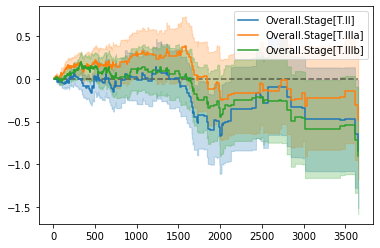

In [67]:
aaf.plot(columns = ['Overall.Stage[T.II]', "Overall.Stage[T.IIIa]", "Overall.Stage[T.IIIb]"])

In [63]:
non_missing_clinical_data = clinical_data.dropna(subset = ["age", "Overall.Stage", "gender"])

cph = CoxPHFitter()
cph.fit(non_missing_clinical_data, duration_col = "Survival.time", event_col = "deadstatus.event", formula = "Overall.Stage + age + gender")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 399 total observations, 47 right-censored observations>
             duration col = 'Survival.time'
                event col = 'deadstatus.event'
      baseline estimation = breslow
   number of observations = 399
number of events observed = 352
   partial log-likelihood = -1831.66
         time fit was run = 2022-12-06 09:17:39 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Overall.Stage[T.II]    -0.08       0.93       0.21            -0.48             0.33                 0.62                 1.40
Overall.Stage[T.IIIa]   0.12       1.13       0.16            -0.18             0.42                 0.83                 1.53
Overall.Stage[T.IIIb]  -0.06       0.94       0.15            -0.35             0.23                 0.71                 1.25
age                     0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
gender[T.male]          0.19       1.20       0.12            -0.06             0.43                 0.95                 1.53

                        cmp to     z    p   -log2(p)
covariate                                           
Overall.Stage[T.II]       0.00 -0.36 0.72       0.48
Overall.Stage[T.IIIa]     0.00  0.77 0.44       1.19
Overall.Stage[T.IIIb]     0.00 -0.41 0.68       0.56
age                       0.00  2.52 0.01       6.43
gender[T.male]            0.00  1.51 0.13       2.94
---
Concordance = 0.55
Partial AIC = 3673.33
log-likelihood ratio test = 13.80 on 5 df
-log2(p) of ll-ratio test = 5.89

## Dividing target variable (survival time) into train-val-test sets

In [86]:
y_train = []
y_val = []
y_test = []

for patient_id in train_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_train.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_train = np.array(y_train)

for patient_id in val_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_val.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_val = np.array(y_val)

for patient_id in test_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  y_test.append(clinical_data.loc[clincal_data_id, "Survival.time"])
y_test = np.array(y_test)

## Dividing event status into train-val-test sets

In [87]:
event_train = []
event_val = []
event_test = []

for patient_id in train_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_train.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_train = np.array(event_train)

for patient_id in val_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_val.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_val = np.array(event_val)

for patient_id in test_patients:
  clincal_data_id = "LUNG1-" + patient_id[-7:-4]
  event_test.append(clinical_data.loc[clincal_data_id, "deadstatus.event"])
event_test = np.array(event_test)

## Apply normalization and resizing to images

In [102]:
X_train = np.array([process_scan(path) for path in train_paths]) # X_train.shape is [sample size, 128, 128, 64]
X_val = np.array([process_scan(path) for path in val_paths])
X_test = np.array([process_scan(path) for path in test_paths])

## Visualize preprocessed image

Dimension of the CT scan is: (128, 128, 64)


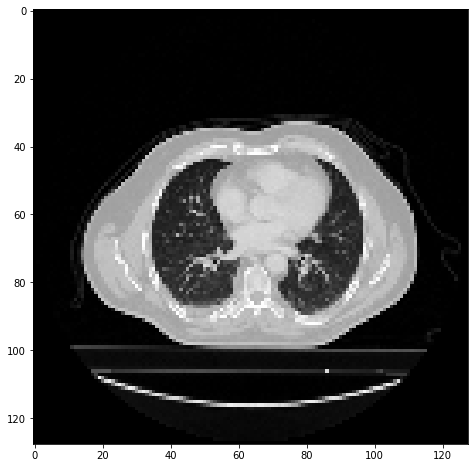

In [78]:
image = X_train[0]
print("Dimension of the CT scan is:", image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")

# Base Model

## Expand dims to enable 3d Conv net

In [79]:
def train_preprocessing(volume, label):
    """Process training data by adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

## Defining data loaders

In [80]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 2

# Augment the on the fly during training.
train_dataset = (
    train_loader
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Only rescale.
validation_dataset = (
    validation_loader
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## Define conv net

In [81]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="linear")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3D_CNN_Base")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3D_CNN_Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                       

## Train model

In [82]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mse"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mse", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
14/14 - 8s - loss: 1210767.3750 - mse: 1210767.3750 - val_loss: 489968.0938 - val_mse: 489968.0938 - 8s/epoch - 604ms/step
Epoch 2/10
14/14 - 3s - loss: 1209427.1250 - mse: 1209427.1250 - val_loss: 478258.7812 - val_mse: 478258.7812 - 3s/epoch - 193ms/step
Epoch 3/10
14/14 - 3s - loss: 1207705.0000 - mse: 1207705.0000 - val_loss: 466578.4062 - val_mse: 466578.4062 - 3s/epoch - 194ms/step
Epoch 4/10
14/14 - 3s - loss: 1205679.8750 - mse: 1205679.8750 - val_loss: 459188.7500 - val_mse: 459188.7500 - 3s/epoch - 190ms/step
Epoch 5/10
14/14 - 3s - loss: 1203402.8750 - mse: 1203402.8750 - val_loss: 455706.2500 - val_mse: 455706.2500 - 3s/epoch - 190ms/step
Epoch 6/10
14/14 - 3s - loss: 1200238.3750 - mse: 1200238.3750 - val_loss: 451157.1250 - val_mse: 451157.1250 - 3s/epoch - 189ms/step
Epoch 7/10
14/14 - 3s - loss: 1198233.1250 - mse: 1198233.1250 - val_loss: 447571.3750 - val_mse: 447571.3750 - 3s/epoch - 190ms/step
Epoch 8/10
14/14 - 3s - loss: 1194195.2500 - mse: 1194195.2500

## Visualize model performance

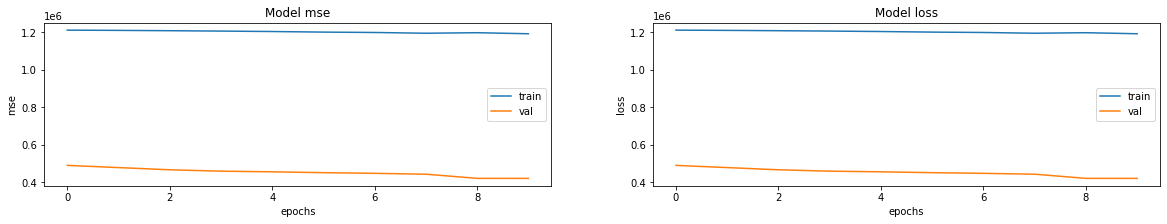

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["mse", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Survival analysis using deep learning

## Expand dims for 3d conv net

In [104]:
X_train = X_train[..., np.newaxis] # X_train.shape = [sample_size, 128, 128, 64, 1]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Define class for extracting batches from data and calculating Cox-proportional hazards from batches

In [140]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind = "mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 8,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 42) -> None:
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, d, c = self.images.shape[1:] # Added c
        images = tf.TensorShape([batch_size, h, w, d, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:

        """
        Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

## Define class for calculating Harrell's C-index

In [132]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

## Defining model architecture tensorflow graphs


In [133]:
class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):

        y_event = tf.expand_dims(y_event, axis=1)

        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = tf.summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = tf.summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                tf.summary.graph(func.graph)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 5 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                tf.summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        tf.summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            tf.summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

In [134]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation='linear')(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3d_cnn_survival_model")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3d_cnn_survival_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_16 (Conv3D)          (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 63, 63, 31, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 63, 63, 31, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 61, 61, 29, 64)    110656    
                                             

## Training the model

In [141]:
train_fn = InputFunction(X_train, y_train, event_train,
                  drop_last=True,
                  shuffle=True)

eval_fn = InputFunction(X_val, y_val, event_val)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("3d_cnn_survival_model"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=15,
)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir 3d_cnn_survival_model

In [142]:
trainer.train_and_evaluate()

Latest checkpoint restored from 3d_cnn_survival_model/ckpt-1.
step 0: mean loss = 1.2229


Validation: loss = 1.1707, cindex = 0.4667
step 5: mean loss = 1.1954
Validation: loss = 1.1589, cindex = 0.4667
Validation: loss = 1.1620, cindex = 0.4667
step 10: mean loss = 0.9114
Validation: loss = 1.1475, cindex = 0.4667
Validation: loss = 1.1357, cindex = 0.4667
step 15: mean loss = 0.7920
Validation: loss = 1.1209, cindex = 0.4667
step 20: mean loss = 0.6810
Validation: loss = 1.1113, cindex = 0.5333
Validation: loss = 1.1092, cindex = 0.5333
step 25: mean loss = 0.5293
Validation: loss = 1.1002, cindex = 0.4667
Validation: loss = 1.0943, cindex = 0.4667
step 30: mean loss = 0.4915
Validation: loss = 1.0911, cindex = 0.4667
step 35: mean loss = 0.4188
Validation: loss = 1.0867, cindex = 0.5333
Validation: loss = 1.0790, cindex = 0.5333
step 40: mean loss = 0.3243
Validation: loss = 1.0792, cindex = 0.5333
Validation: loss = 1.0824, cindex = 0.5333
Saved checkpoint for step 45: 3d_cnn_survival_model/ckpt-2


## Predict survival functions

In [143]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model.coxph import BreslowEstimator


class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

In [144]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(X_train).batch(8)

predictor = Predictor(model, trainer.model_dir)
train_predictions = predictor.predict(train_pred_fn)

breslow = BreslowEstimator().fit(train_predictions, event_train, y_train)

Latest checkpoint restored from 3d_cnn_survival_model/ckpt-2.


Latest checkpoint restored from 3d_cnn_survival_model/ckpt-2.


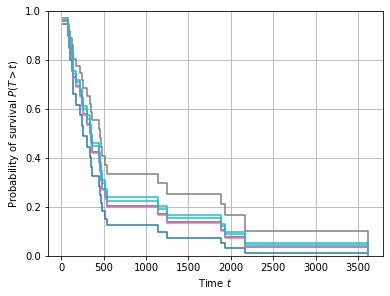

In [146]:
pred_ds = tf.data.Dataset.from_tensor_slices(
    X_test).batch(8)
test_predictions = predictor.predict(pred_ds)

sample_surv_fn = breslow.get_survival_function(test_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_test):
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}")

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()